In [26]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timer Frequency

Reference Manual 0365

pg 555

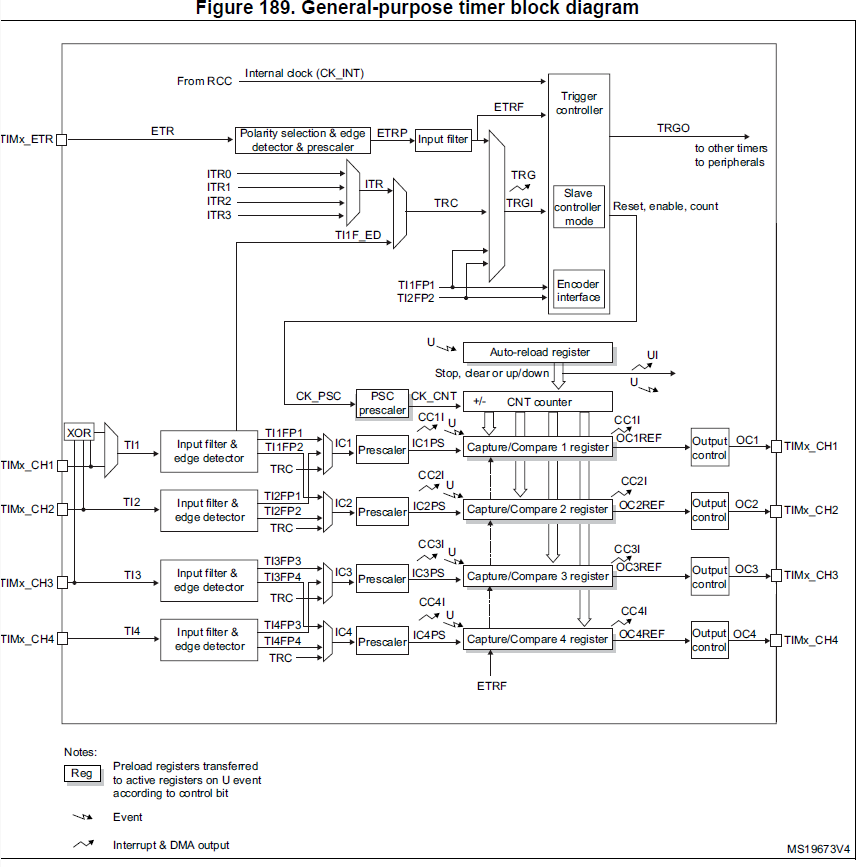

pg 119

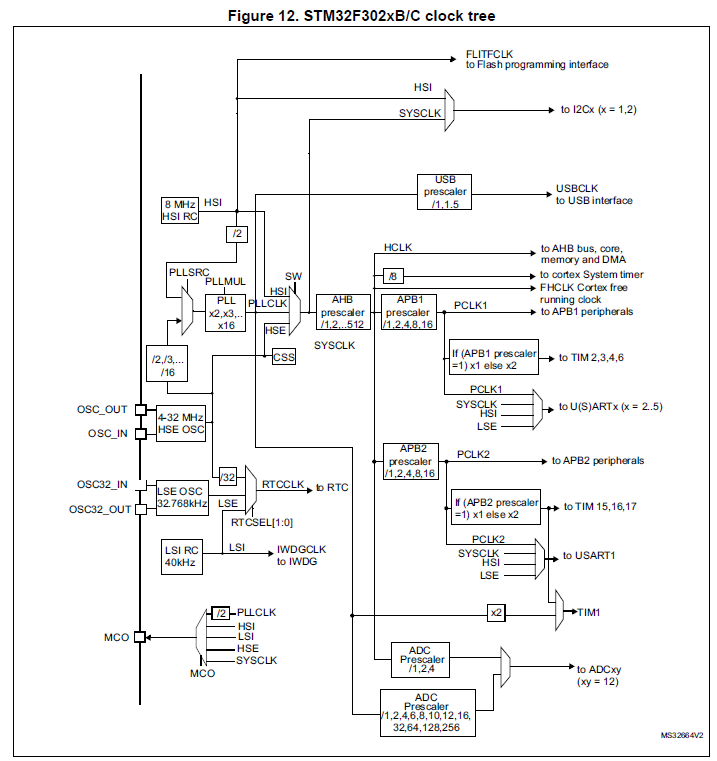

- `CK_PSC` = Clock input to timer before presaler
- `CK_CNT` = Clock Counter after prescaler

$$
\begin{align}
T_{\text{CK\_CNT}} &= (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
\\
T_{\text{UEV}} &= (\text{ARR} + 1) T_{\text{CK\_CNT}} \\
T_{\text{UEV}} &= (\text{ARR} + 1) (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
\frac{1}{f_{\text{UEV}}} &= (\text{ARR} + 1) (\text{PSC} + 1) \frac{1}{f_{\text{CK\_PSC}}} \\
f_{\text{UEV}} &= \frac{f_{\text{CK\_PSC}}}{(\text{ARR} + 1) (\text{PSC} + 1)} \\
\end{align}
$$

If target `UEV` frequency, `CK_PSC`, and `PSC` is known, we can find associated `ARR`

$$
\begin{align}
\frac{f_{\text{UEV}} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} &= \frac{1}{(\text{ARR} + 1) } \\
\text{ARR} + 1 &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} \\
\text{ARR} &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} - 1 \\
\end{align}
$$

In [27]:
f_CK_PSC = Q(64e6, 'Hz')
PSC = 0

def calc_f_UEV(f_CK_PSC, PSC, ARR):
    return round(f_CK_PSC / ((ARR + 1) * (PSC + 1)))

def calc_ARR(f_UEV, f_CK_PSC, PSC):
    return round((f_CK_PSC / (f_UEV * (PSC + 1))) - 1)

for f in Q([1, 20e3, 100e3], 'Hz'):
    f_UEV = f
    ARR = calc_ARR(f_UEV=f_UEV, f_CK_PSC=f_CK_PSC, PSC=PSC)
    print(f"To achieve {f_UEV} Update Event ({(1/f_UEV).to('usec'):.3f}), ARR should be {ARR}")

ARR = 1000
f_UEV = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR)
print(f"When ARR is {ARR}, f_UEV is {f_UEV} ({(1/f_UEV).to('usec'):.3f})")

To achieve 1.0 hertz Update Event (1000000.000 microsecond), ARR should be 63999999.0 dimensionless
To achieve 20000.0 hertz Update Event (50.000 microsecond), ARR should be 3199.0 dimensionless
To achieve 100000.0 hertz Update Event (10.000 microsecond), ARR should be 639.0 dimensionless
When ARR is 1000, f_UEV is 63936.0 hertz (15.641 microsecond)


# Addressable LED Pulse Study

Recall from above

- `CK_PSC` = Clock input to timer before presaler
- `CK_CNT` = Clock Counter after prescaler

$$
\begin{align}
T_{\text{CK\_CNT}} &= (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
\end{align}
$$

A pulse with duration $T_{\text{PULSE}}$ would then change state when $CCR$ is reached.

$$
\begin{align}
T_{\text{PULSE}} &= \text{CCR} \cdot T_{\text{CK\_CNT}} \\
T_{\text{PULSE}} &= \text{CCR} (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
T_{\text{PULSE}} &= \frac{\text{CCR} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\\
\text{CCR} &= \frac{T_{\text{PULSE}}}{(\text{PSC} + 1) T_{\text{CK\_PSC}}} \\
\text{CCR} &= \frac{T_{\text{PULSE}} f_{\text{CK\_PSC}}}{(\text{PSC} + 1)} \\
\end{align}
$$

In [28]:
f_CK_PSC = Q(64e6, 'Hz')
PSC = 0
# f_UEV = Q(800e3, 'Hz')
# ARR = calc_ARR(f_UEV=f_UEV, f_CK_PSC=f_CK_PSC, PSC=PSC)
# print(f"To achieve {f_UEV} Update Event ({(1/f_UEV).to('usec'):.3f}), ARR should be {ARR}")

ARR = 79
f_UEV = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR)
print(f"When ARR is {ARR}, f_UEV is {f_UEV} ({(1/f_UEV).to('usec'):.3f})")

def calc_CCR_from_T_PULSE(T_PULSE, f_CK_PSC, PSC):
    return round((T_PULSE * f_CK_PSC) / (PSC + 1))

def calc_T_PULSE_from_CCR(CCR, f_CK_PSC, PSC):
    return (CCR * (PSC + 1)) / f_CK_PSC

for T_PULSE in Q([300, 350, 700, 750], 'nsec'):
    CCR = round(calc_CCR_from_T_PULSE(T_PULSE=T_PULSE, f_CK_PSC=f_CK_PSC, PSC=PSC).to('')) # need to re-round with dimension change
    print(f"To achieve pulse duration of {T_PULSE}, CCR should be {CCR}")

for CCR in Q([19, 48], ''):
    T_PULSE = calc_T_PULSE_from_CCR(CCR=CCR, f_CK_PSC=f_CK_PSC, PSC=PSC)
    print(f"When CCR is {CCR}, T_PULSE is {T_PULSE.to('nsec'):.3f}")

When ARR is 79, f_UEV is 800000.0 hertz (1.250 microsecond)
To achieve pulse duration of 300 nanosecond, CCR should be 19.0 dimensionless
To achieve pulse duration of 350 nanosecond, CCR should be 22.0 dimensionless
To achieve pulse duration of 700 nanosecond, CCR should be 45.0 dimensionless
To achieve pulse duration of 750 nanosecond, CCR should be 48.0 dimensionless
When CCR is 19 dimensionless, T_PULSE is 296.875 nanosecond
When CCR is 48 dimensionless, T_PULSE is 750.000 nanosecond


In [29]:
a = Q(1.5, 'nsec')
print(round(a))

2.0 nanosecond
